# Boosted Trees Regression (BQML)

In [ ]:
###########################################################################
#
#  Copyright 2021 Google Inc.
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      https://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
# This solution, including any related sample code or data, is made available
# on an “as is,” “as available,” and “with all faults” basis, solely for
# illustrative purposes, and without warranty or representation of any kind.
# This solution is experimental, unsupported and provided solely for your
# convenience. Your use of it is subject to your agreements with Google, as
# applicable, and may constitute a beta feature as defined under those
# agreements.  To the extent that you make any data available to Google in
# connection with your use of the solution, you represent and warrant that you
# have all necessary and appropriate rights, consents and permissions to permit
# Google to use and process that data.  By using any portion of this solution,
# you acknowledge, assume and accept all risks, known and unknown, associated
# with its usage, including with respect to your deployment of any portion of
# this solution in your systems, or usage in connection with your business,
# if at all.
###########################################################################

## 0) Dependencies

In [1]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

project_name = 'OnStar_RBA_0708' #add proj name and dataset

In [2]:
# Google credentials authentication libraries
from google.colab import auth
auth.authenticate_user()

# BigQuery Magics
'''
BigQuery magics are used to run BigQuery SQL queries in a python environment.
These queries can also be run in the BigQuery UI
'''

from google.cloud import bigquery
from google.cloud.bigquery import magics
magics.context.project = project_name #update project name
client = bigquery.Client(project=magics.context.project)
%load_ext google.cloud.bigquery
bigquery.USE_LEGACY_SQL = False


# data processing libraries
import numpy as np
import pandas as pd


# modeling and metrics
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

!pip install relativeImp
from relativeImp import relativeImp
!pip install shap
import shap

# visutalization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from google.colab import files

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 17.1 MB/s eta 0:00:00


## 1) Import dataset

Import the data using the bigquery magics (%% command).
Pulls all of the data from the cleaned data table and stores into a dataframe "df"

In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

In [ ]:
# %%bigquery df
# SELECT *
# FROM `.RBA_demo.cleaned_data`
# ORDER BY date; #update project name

In [21]:
#update file name
#file_name = 'https://raw.githubusercontent.com/zzWIInTer/zz_onstar_rba/master/final_cleaned_data.csv'
#file_name = 'https://raw.githubusercontent.com/zzWIInTer/zz_onstar_rba/master/final_cleaned_data_0708.csv'
#file_name = 'https://raw.githubusercontent.com/zzWIInTer/zz_onstar_rba/master/FY2024_final_cleaned_data_0725.csv'
#file_name = 'https://raw.githubusercontent.com/zzWIInTer/zz_onstar_rba/master/final_cleaned_data_08262024.csv'
file_name = 'https://raw.githubusercontent.com/zzWIInTer/zz_onstar_rba/master/FY2024_final_cleaned_data_08262024.csv'
df_raw = pd.read_csv(file_name)
df_raw.fillna(0, inplace=True)


#df = df_raw.drop(columns = ['DIV_WYG_PPl21_0p0_0d0_12']).copy()
df = df_raw.copy()

df.head()

,Date,A_OC_GOOGLE_SHOPPING,Is_NYE,C_DIV_BUY_CONNECTEDl21_0p0_0d0_0,C_DIV_BUY_ESSENTIALSl21_0p0_0d0_12,C_DIV_BUY_PREMIUMl21_0p0_0d0_0,C_DIV_BUY_SSl21_0p0_0d0_06,C_DIV_CONN_DATAl21_0p0_0d0_06,C_DIV_CONN_REMOTEl21_0p0_0d0_12,C_DIV_CONN_TRYl21_0p0_0d0_12,...,DIV_PLANPAGE_CONNl21_0p0_0d0_0,DIV_PLANPAGE_ESSl21_0p0_0d0_06,DIV_PLANPAGE_HOMEl21_0p0_0d0_12,DIV_WYG_PPl21_0p0_0d0_0,OC_APP_Accessl21_0p0_0d0_06,OC_PAGE_ESSl21_0p0_0d0_0,OC_PAGE_PREFl21_0p0_0d0_06,OC_PAGE_PREMl21_0p0_0d0_06,SC_BUYNOWl21_0p0_0d0_12,SC_SHOPNOWl21_0p0_0d0_06
0,1/1/2024,354,1.0,-1.828030,-2.526448,-2.104763,-2.063396,-0.729938,-1.250854,-1.956002,...,-2.219101,-1.762813,-1.998409,-1.529526,-2.932118,-0.948632,-2.519696,-1.567837,-0.172139,-0.314432
1,1/2/2024,1151,0.0,-1.498295,-1.701873,-1.692545,-1.611430,0.193948,-1.511079,-1.263386,...,-0.652023,0.663929,-0.551123,0.694164,-0.204862,3.622656,-1.369898,-0.598367,-0.881182,-1.108435
2,1/3/2024,1259,0.0,-1.278471,-0.686296,-0.661999,-1.714378,-1.520723,0.331041,-0.917079,...,-0.090557,0.328018,-0.065951,1.056014,-0.331250,0.567805,-1.168232,-0.461871,-0.172139,-0.314432
3,1/4/2024,1210,0.0,-0.893780,-1.040351,-1.417733,-0.717541,-0.060512,-0.983781,0.512837,...,-0.392240,0.263726,-0.283491,0.420674,-0.842920,-0.054887,-1.077934,-0.663535,-0.881182,-0.263751
4,1/5/2024,1200,0.0,-0.564044,-2.027976,-1.692545,-0.782825,-0.358035,1.056933,-0.436717,...,-0.140838,0.887628,-0.435376,0.342834,-0.799820,-0.186751,-1.401366,-0.568137,3.856514,0.580933


In [22]:
#df.columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 34 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Date                                136 non-null    object 
 1   A_OC_GOOGLE_SHOPPING                136 non-null    int64  
 2   Is_NYE                              136 non-null    float64
 3   C_DIV_BUY_CONNECTEDl21_0p0_0d0_0    136 non-null    float64
 4   C_DIV_BUY_ESSENTIALSl21_0p0_0d0_12  136 non-null    float64
 5   C_DIV_BUY_PREMIUMl21_0p0_0d0_0      136 non-null    float64
 6   C_DIV_BUY_SSl21_0p0_0d0_06          136 non-null    float64
 7   C_DIV_CONN_DATAl21_0p0_0d0_06       136 non-null    float64
 8   C_DIV_CONN_REMOTEl21_0p0_0d0_12     136 non-null    float64
 9   C_DIV_CONN_TRYl21_0p0_0d0_12        136 non-null    float64
 10  C_DIV_GETNOW_CONNl21_0p0_0d0_12     136 non-null    float64
 11  C_DIV_GETNOW_ESSl21_0p0_0d0_06      136 non-n

In [8]:
#df.describe()

In [9]:
#df.head()

Set KPI and date columns

In [23]:
kpi_col = "A_OC_GOOGLE_SHOPPING" #@param {type:"string"}
date_col = "Date" #@param {type:"string"}

## 2) Run the RBA Model in BQML

In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

This model also includes a train/test split of 90/10 using the "data_split_method", "data_split_eval_fraction", and "data_split_col" parameters.

Since this data is time series, we use a sequential split with the date column as the reference point.

We suggest using a train/test split to validate model performance, but for attribution results we suggest running the model on the full dataset.

In [ ]:
# %%bigquery
# CREATE OR REPLACE MODEL `.RBA_demo.RBA_model`  #update project name
# OPTIONS (model_type='boosted_tree_regressor',
#         #data_split_method = 'SEQ', #use these options for train/test splits
#         #data_split_eval_fraction = 0.1,
#         #data_split_col = 'date',
#         input_label_cols = ['y1'],
#         enable_global_explain = True)
# AS SELECT * EXCEPT(date)
#     FROM `.RBA_demo.cleaned_data`
#     #ORDER BY date; #update project name

In [24]:
import xgboost as xgb

# Prepare your features and target variable
X_all = df.drop(columns = [kpi_col,date_col], axis=1)  # Assuming 'y1' is your target variable
y = df[kpi_col]

# Create the XGBoost model
model_all = xgb.XGBRegressor(objective ='reg:squarederror', enable_categorical=True)

# Fit the model
model_all.fit(X_all, y)

# Evaluate the model on the test data
#y_pred = model_all.predict(X_all)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [25]:
# Calculate the index for splitting the data (e.g., last 10% for testing)
split_index = int(len(df) * 0.9)

# Split the data into training and testing sets
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

# Separate features and target variable for both sets
X_train = train_df.drop([kpi_col, date_col], axis=1)
y_train = train_df[kpi_col]
X_test = test_df.drop([kpi_col, date_col], axis=1)
y_test = test_df[kpi_col]

# Create the XGBoost model
model_train = xgb.XGBRegressor(objective ='reg:squarederror', enable_categorical=True)

# Fit the model
model_train.fit(X_train, y_train)

# Evaluate the model on the test data
#y_pred_test = model.predict(X_test)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

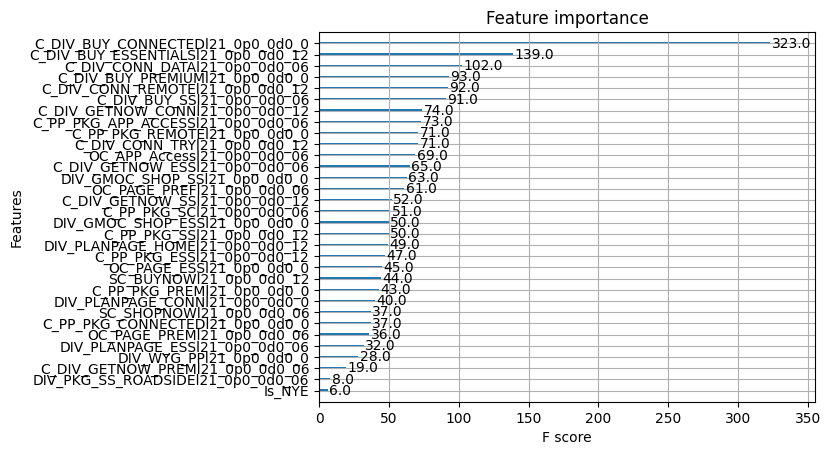

In [26]:
xgb.plot_importance(model_all)

### 2.1) Print the model evaluation metrics

In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

Call the model evaluation metrics from the model and save to a dataframe "evaluation_metrics".

For linear regression models The ML.EVALUATE function returns: mean absolute error,mean squared erorr, mean squared log error, median absolute error, r-squared, and explained variance metrics.

In [ ]:
# %%bigquery evaluation_metrics
# SELECT *
# FROM ML.EVALUATE(MODEL `.RBA_demo.RBA_model`) #update project name

In [ ]:
# evaluation_metrics

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming 'model' is your trained model, and you have 'X_test' and 'y_test'
y_pred_test = model_train.predict(X_test)

# Calculate the metrics
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_test)


# Print the metrics
print(f"Model Fit Test")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")
print()



# Assuming 'model' is your trained model, and you have 'X_test' and 'y_test'
y_pred = model_all.predict(X_all)

# Calculate the metrics
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)


print(f"Model Fit All")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")



Model Fit Test
Mean Absolute Error (MAE): 98.78994750976562
Mean Squared Error (MSE): 14673.667929407475
Root Mean Squared Error (RMSE): 121.13491622735154
R-squared (R2): -1.0836935897322717

Model Fit All
Mean Absolute Error (MAE): 0.00034960578469669115
Mean Squared Error (MSE): 2.8806628988069647e-07
Root Mean Squared Error (RMSE): 0.0005367180729961462
R-squared (R2): 0.9999999999951752


WARNING: make sure evaluation metrics displayed in Colab match the BQ UI.

### 2.2) Visualize model fit

In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

Select the predicted conversions (y1) of the model and actual conversions from the data (y1) using the ML.PREDICT function

In [ ]:
# %%bigquery model_predictions
# SELECT
#   *
# FROM
#   ML.PREDICT(MODEL `.RBA_demo.RBA_model`, #update project name
#     (
#     SELECT
#         *
#     FROM
#       `.RBA_demo.cleaned_data`
#       ORDER BY date)); #update project name

Visualize the model fit by comparing predicted vs. actual data.

In [28]:
results = pd.DataFrame()
results['actual'] = df[kpi_col]
results['predicted'] = y_pred

In [29]:
fig = px.line(results.sort_index())
fig.show()

## 3) Calculate contribution of each digital media tactic on conversions

To determine feature attribution, we use BQML's Global Explainability methodology. ML.GLOBAL_EXPLAIN provides explanations for the entire model by aggregating the local explanations of the evaluation data

In [ ]:
# %%bigquery feature_importance
# SELECT
#   *
# FROM
#   ML.GLOBAL_EXPLAIN(MODEL `RBA_demo.RBA_model`);

In [ ]:
#feature_importance

In [ ]:
# sum_feature_imp = feature_importance.attribution.sum()
# scale_factor = 0.99 # pulled from BQ UI

# feature_importance['attribution %'] = feature_importance.attribution / (sum_feature_imp / scale_factor)
# feature_importance.sort_values(by = 'attribution %', ascending = False)

In [ ]:
# feature_importance['attribution %'].sum()

In [30]:
# For xgboost
importances = model_all.feature_importances_

feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': importances})


In [31]:
sum_importance = feature_importance.importance.sum()
scale_factor = 0.99  # Adjust as needed

feature_importance['attribution %'] = feature_importance.importance / (sum_importance / scale_factor)
feature_importance.sort_values(by='attribution %', ascending=False, inplace=True)


In [32]:
total_scaled_importance = feature_importance['attribution %'].sum()
print(total_scaled_importance)


0.9900001


## 4) Export Final Results

In [33]:
final_results_df = feature_importance[['feature','attribution %']]
final_results_df.to_csv('rba_final_output_boosted.csv', encoding = 'utf-8-sig')
files.download('rba_final_output_boosted.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>